In [3]:
import pandas as pd
import shap

In [4]:
wine_df = pd.read_csv("../data/winequality-white.csv")

In [5]:
wine_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [6]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [7]:
wine_df['quality'].unique()

array([6, 5, 7, 8, 4, 3, 9])

In [8]:
wine_df["quality"] = wine_df["quality"].replace({3: 0, 4: 1, 5: 2, 6:3, 7:4,8:5,9:6})

In [9]:
wine_df['quality'].unique()

array([3, 2, 4, 5, 1, 0, 6])

In [10]:
from sklearn.model_selection import train_test_split

X = wine_df.drop('quality', axis=1)
y = wine_df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[18:11:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [12]:
score

0.6683673469387755

In [13]:
row_4550_X = X.iloc[[4550]]
row_4550_X
wine_df.iloc[[4550]]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4550,6.8,0.23,0.33,1.9,0.047,20.0,101.0,0.9914,3.1,0.46,11.1,3


In [14]:
#generate a prediction for the row
rand_pred = model.predict(row_4550_X)
rand_proba = model.predict_proba(row_4550_X)

print(f'Predicted Probability (Quality): {rand_proba}')
print(f'Predicted Quality (0 - 6): {rand_pred}','\n')

Predicted Probability (Quality): [[7.5840500e-05 2.5345965e-03 7.7761546e-02 8.5330224e-01 6.0022540e-02
  6.2458045e-03 5.7418230e-05]]
Predicted Quality (0 - 6): [3] 



### Using SHAP to explain the model

Greatly oversimplyfing, SHAP takes the base value for the dataset, and goes through the input data row-by-row and feature-by-feature varying its values to detect how it changes the base prediction holding all-else-equal for that row. For non-linear models the order in which the features are added matters so SHAP values arise from averaging the values across all possible orderings. In so doing, SHAP is essentially building a mini explainer model for a single row-prediction pair to explain how this prediction was reached. 

In [15]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [16]:
shap_values_XGB_test = explainer.shap_values(X_test)
shap_values_XGB_train = explainer.shap_values(X_train)

In [19]:
#Force plot for observation # 4550
i = 4550
shap_values = explainer.shap_values(X.iloc[[i]])
#shap.initjs()
for which_class in range(0,7):
    display(shap.force_plot(explainer.expected_value[which_class], shap_values[which_class], X.iloc[[i]], 
                            out_names=which_class))


This first obvious difference is SHAP will output a seperate matrix for each class prediction for the given input row. This means we have 7 plots to look at instead of just one. This is useful because a regulator may be just as interested in why you made a decision as they are in why you didn't make another. Thankfully its easy to loop through each class and generate the appropriate graphs.

In [20]:
display(pd.DataFrame(data=shap_values[3], columns=X.columns, index=[4550]).transpose().sort_values(by=4550, ascending=True))


,4550
residual sugar,-0.091027
density,-0.073598
fixed acidity,-0.040083
total sulfur dioxide,-0.017071
sulphates,0.016944
citric acid,0.031065
free sulfur dioxide,0.048389
chlorides,0.065292
pH,0.117371
alcohol,0.122997


The above table is the full list of features and their SHAP additive weights for the predicted category for  observation # 4550. 'volatile acidity', 'alcohol', 'pH' are the top 3 features along with 'chlorides' , 'free sulphur dioxide' and 'citric acid' that contributed most in categorizing this observation to Class 3.

In [21]:
#Display all features and SHAP values for all categories
df1=pd.DataFrame([shap_values[0][0]], columns=X.columns, index=[0])
df2=pd.DataFrame([shap_values[1][0]], columns=X.columns, index=[1])
df3=pd.DataFrame([shap_values[2][0]], columns=X.columns, index=[2])
df4=pd.DataFrame([shap_values[3][0]], columns=X.columns, index=[3])
df5=pd.DataFrame([shap_values[4][0]], columns=X.columns, index=[4])

df6=pd.DataFrame([shap_values[5][0]], columns=X.columns, index=[5])

df7=pd.DataFrame([shap_values[6][0]], columns=X.columns, index=[6])

df=pd.concat([df1,df2,df3,df4,df5,df6,df7])
display(df.transpose())


,0,1,2,3,4,5,6
fixed acidity,-0.533823,0.071442,-0.118994,-0.040083,0.110674,0.419485,-0.312883
volatile acidity,-0.371729,-0.868193,-0.145322,0.159594,0.055672,0.087770,0.064189
citric acid,-0.399960,-0.575413,-0.116109,0.031065,0.101422,0.123834,-0.261606
residual sugar,-0.330041,0.080871,0.357852,-0.091027,-0.248605,-0.651310,-0.105013
chlorides,-0.290826,0.042910,0.073451,0.065292,-0.304749,0.119382,-0.749602
free sulfur dioxide,-0.212489,0.034266,0.170538,0.048389,-0.420023,-0.857923,-0.050555
total sulfur dioxide,-0.450864,-0.206438,-0.248529,-0.017071,-0.034446,-0.071160,-0.073979
density,0.112461,-0.837690,-0.890588,-0.073598,-0.648921,-0.103470,-0.670346
pH,-0.660168,0.027114,0.151763,0.117371,-0.151191,-0.497873,-0.514774
sulphates,-0.481326,-0.325153,0.036401,0.016944,-0.026501,-0.155268,0.106899


In [22]:
import numpy as np


#define a function to convert logodds to probability for multi-class 
def logodds_to_proba(logodds):
    return np.exp(logodds)/np.exp(logodds).sum()

#generate predictions for our row of data and do conversion
logodds = model.predict(X.iloc[[i]], output_margin=True)
probas = model.predict_proba(X.iloc[[i]])
for which_class in range(0,7):
    base_val = explainer.expected_value[which_class]
    pred_val = explainer.expected_value[which_class] + shap_values[which_class][0].sum() #delta between base value and pred value
    converted_prob_val = logodds_to_proba(logodds)[0][which_class]
    proba = probas[0][which_class]

    print('Class: ',which_class)
    print('Base value: ', base_val)
    print('Prediction value: ', pred_val)
    print('Converted Proba value:', converted_prob_val)
    print('Proba value:', proba, '\n')

Class:  0
Base value:  -3.2162473
Prediction value:  -7.064247
Converted Proba value: 7.584052e-05
Proba value: 7.58405e-05 

Class:  1
Base value:  -0.87093997
Prediction value:  -3.5550902
Converted Proba value: 0.002534597
Proba value: 0.0025345965 

Class:  2
Base value:  1.3956823
Prediction value:  -0.13147879
Converted Proba value: 0.07776155
Proba value: 0.077761546 

Class:  3
Base value:  1.9241165
Prediction value:  2.2639885
Converted Proba value: 0.85330224
Proba value: 0.85330224 

Class:  4
Base value:  0.8071104
Prediction value:  -0.39040542
Converted Proba value: 0.060022537
Proba value: 0.06002254 

Class:  5
Base value:  -0.8650218
Prediction value:  -2.6532154
Converted Proba value: 0.006245806
Proba value: 0.0062458045 

Class:  6
Base value:  -4.3176274
Prediction value:  -7.3425183
Converted Proba value: 5.741824e-05
Proba value: 5.741823e-05 



### Explaining Single Feature
To understand the effect a single feature has on the model output, we can plot a SHAP value of that feature vs. the value of the feature for all instances in the dataset.     


The chart below shows the change in wine quality as the alcohol value changes. Vertical dispersions at a single value show interaction effects with other features. SHAP automatically selects another feature for coloring to make these interactions easier to see:

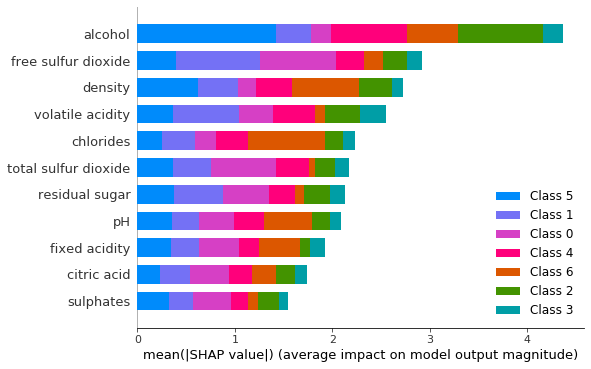

In [23]:
shap.summary_plot(shap_values_XGB_test, X_test)

High alcohol value increases the predicted wine quality.                  

For 'alcohol' , mean(|SHAP|) is about 1.5 on Classs 5, and (1.8-1.5)=0.3 on Class 1, it means 'alcohol' influence predicting Class 5 more than Class 1. Also the 'alcohol' is the most influential feature.**



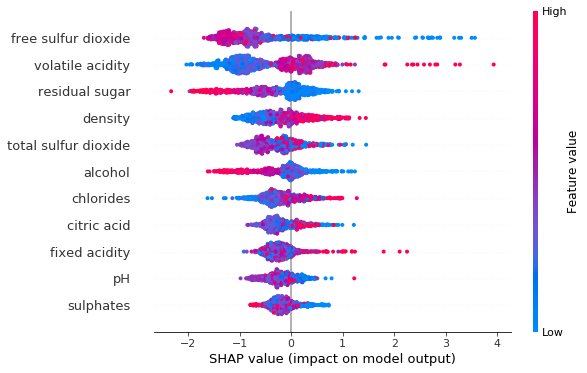

In [24]:
#Summary dot plot for Class 1
shap.summary_plot(shap_values = shap_values_XGB_test[1], features = X_test, max_display=20, plot_type='dot')


SHAP dependence plots show the effect of a single (or two) feature across the whole dataset. They plot a feature’s value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature can be chosen for coloring to highlight possible interactions.                   

The dependence plot in SHAP also does one other thing. It picks another feature, which is having the most interaction with the feature we are investigating and colors the dots according to the feature value of that feature.               

When we don't specify an interaction_index, the strongest one is automatically chosen for us.             


In the case of 'alcohol', it is 'free sulphur dioxide' that the method picked for Class 1. And we can see that most of the dispersion you find on the 'alcohol' axis is explained by 'free sulphur dioxide'.

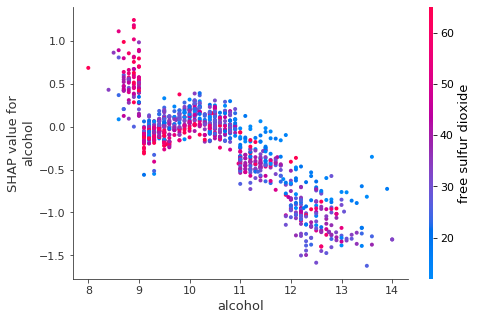

In [25]:
#Dependence plot for class 1
shap.dependence_plot("alcohol",
                     shap_values_XGB_test[1],
                     features=X_test,
                     feature_names= X_test.columns,
                     )

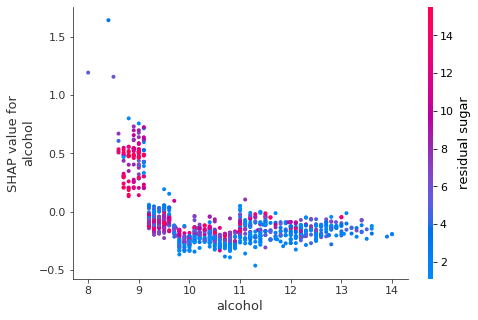

In [26]:
#Dependence plot for class 0
shap.dependence_plot(ind='alcohol',
                     shap_values=shap_values_XGB_test[0], 
                     features=X_test,  
                     display_features=X_test)

### Waterfall plot
One of the fundemental properties of Shapley values is that they always sum up to the difference between 
the game outcome when all players are present and the game outcome when no players are present. 
For machine learning models this means that SHAP values of all the input features will always sum up 
to the difference between baseline (expected) model output and the current model output for the 
prediction being explained. The easiest way to see this is through a waterfall plot that starts our 
background prior expectation for a home price 𝐸[𝑓(𝑋)], and then adds features one at a time until we reach the current model output 𝑓(𝑥):                              
In simpler words, the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]                             

Waterfall plot for Class 1

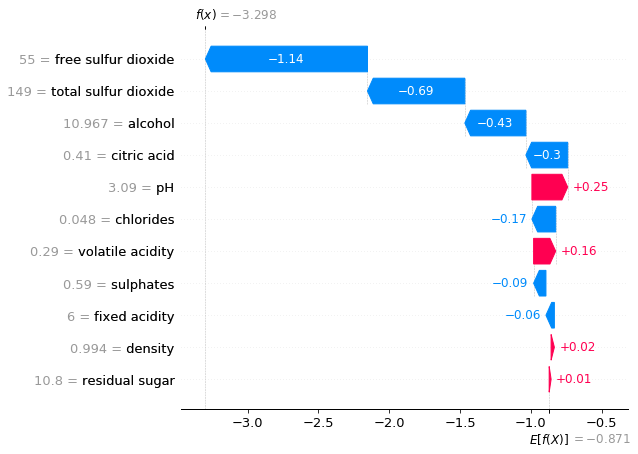

In [27]:
shap.plots._waterfall.waterfall_legacy( explainer.expected_value[1],
                                        shap_values_XGB_test[1][0,:], features=X_test.iloc[0], 
                                        feature_names= X_test.columns,
                                        max_display=12)



It is interesting to note that having a free sulphur dioxide of 55 dramatically reduces this wine's predicted probability to Class 1 (i.e bad wine quality) where as a pH value of 3.09 increased its predicted probability  for this class.

### Feature Importance with Shap

This basically takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.           

Red arrows represent feature effects (SHAP values) that drives the prediction value higher while blue arrows are those effects that drive the prediction value lower. Each bar’s size represents the magnitude of the corresponding feature’s effect.  


Feature importance for Class 0, Class 1 and Class 2

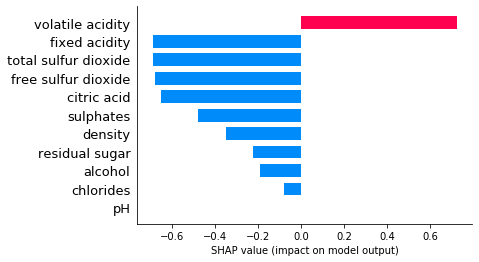

In [28]:
#shap_values = explainer.shap_values(X)
shap.bar_plot(shap_values_XGB_test[0][1,:], feature_names=X_test.columns, max_display=len(X_test.columns.values))

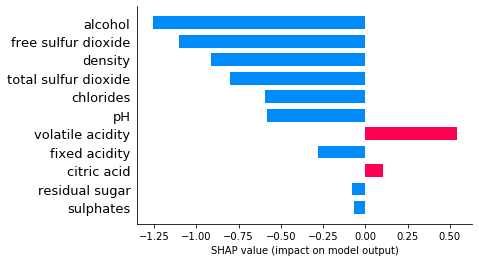

In [29]:
shap.bar_plot(shap_values_XGB_test[1][1,:], feature_names=X_test.columns, max_display=len(X_test.columns.values))

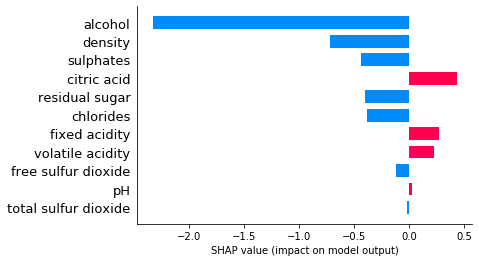

In [30]:
shap.bar_plot(shap_values_XGB_test[2][1,:], feature_names=X_test.columns, max_display=len(X_test.columns.values))

### Force plots
Force plots are suitable for row-wise SHAP analysis. It takes in a single row and shows in a rank order how each of the features contributed to the prediction. 

In [31]:
shap.force_plot(explainer.expected_value[1], shap_values_XGB_test[1][0,:], X_test.iloc[0,:])

Force plots can be made interactive by plotting it with more data points. Here we plotted it with 1000 observations of the data. By hovering mouse pointer over the regions of plot, we can observe shap values interactively

In [32]:
shap.force_plot(explainer.expected_value[1], shap_values_XGB_test[1][:1000,:], features=X_test,feature_names=X_test.columns)


As SHAP values try to isolate the effect of each individual feature, they can be a better indicator of the similarity between examples. Thus SHAP values can be used to cluster examples. Here, each example is a vertical line and the SHAP values for the entire dataset is ordered by similarity. The SHAP package renders it as an interactive plot and we can see the most important features by hovering over the plot. 

Compare the force plot to the decision plot below. The decision plot’s straight vertical line marks the model’s base value. The colored line is the prediction. Feature values are printed next to the prediction line for reference. Starting at the bottom of the plot, the prediction line shows how the SHAP values (i.e., the feature effects) accumulate from the base value to arrive at the model’s final score at the top of the plot. (Roughly speaking, this is similar to a statistical linear model where the sum of effects, plus an intercept, equals the prediction.) Decision plots are literal representation of SHAP values, making them easy to interpret.

### Decision plot

 As like the summary plot, it gives an overall picture of contribution to prediction. From bottom to top of the decision plot, shap values are cumulatively added to the base value of the model in determining the output values.

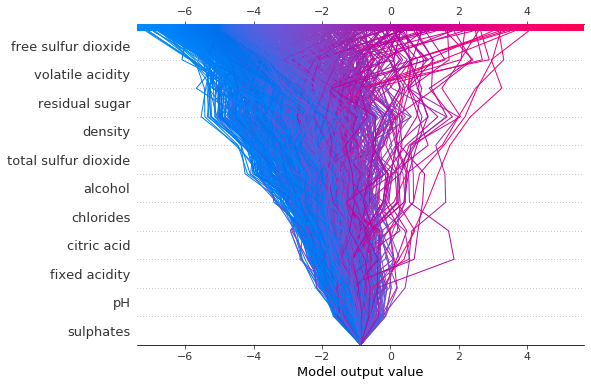

In [33]:
shap.decision_plot(explainer.expected_value[1],
                         shap_values_XGB_test[1],
                   feature_names= X_test.columns.to_list()
                   )

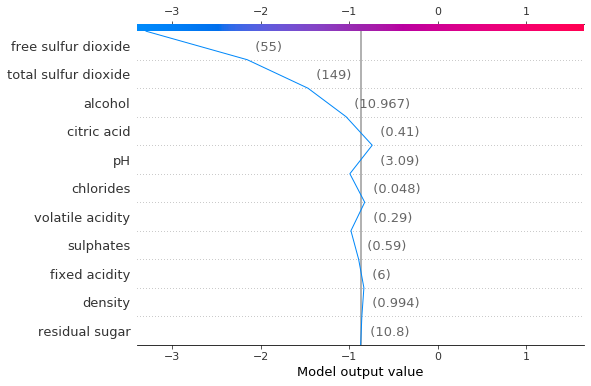

In [34]:
shap.decision_plot(explainer.expected_value[1],
                         shap_values_XGB_test[1][:1,:],
                   feature_names= X_test.columns.to_list(),
                   features= X_test
                   #link= "logit"
                   )

The Decision Plot shows essentially the same information than the Force Plot. The grey vertical line is the base value and the blue line indicates if each feature moved the output value to a higher or lower value than the average prediction.              
This plot can be a little bit more clear and intuitive than the previous one, especially when there are many features to analyze. In the Force Plot the information may look very condensed when the number of predictors is high.

### PDP Plot

Shows the marginal effect that a feature has on the predicted outcome of a machine learning model.
Here in this plot, the x-axis represents the value of feature 'alcohol', and the y-axis represents the predicted value. The solid line in the shaded area shows how the average prediction varies as the value of 'alochol' changes.                 
The gray horizontal line in the plot below represents the expected value of the model when applied to the wine dataset. The vertical gray line represents the average value of the 'alcohol' feature. Note that the blue partial dependence plot line (which the is average value of the model output when we fix the 'alcohol' feature to a given value) always passes through the interesection of the two gray expected value lines. We can consider this intersection point as the "center" of the partial dependence plot with respect to the data distribution.

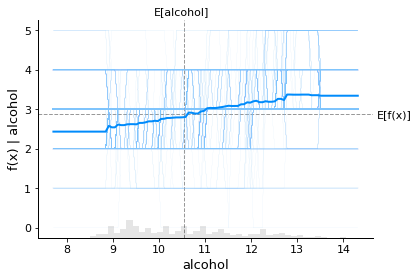

In [35]:
shap.partial_dependence_plot("alcohol",
                             model.predict,
                             data = X_test,
                             feature_names=X_test.columns,
                             model_expected_value=True,
                             feature_expected_value=True,
                             ice=True
                             )